In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

d:\minorProject\WDSS\jupyter_notebooks
d:\minorProject\WDSS


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np

from utils.image_utils import ImageUtils

In [18]:
import zipfile
from enum import Enum

from typing import List, Tuple, Dict

class GB_Type(Enum):
    """G-Buffer types for the dataset.
    """
    BASE_COLOR = 'BaseColor'
    DIFFUSE_COLOR = 'DiffuseColor'
    MOTION_VECTOR = 'MotionVector'
    NoV = 'NoV' # Dot product of normal and view vector
    DEPTH = 'SceneDepth'
    NORMAL = 'WorldNormal'

class WDSSDatasetCompressed(Dataset):
    FRAME_PATHS = {
        'SceneName': 'Asian_Village_Demo',
        'HR_FOLDER': 'High_Res',
        'LR_FOLDER': 'Low_Res',
        'HR_GB_FOLDER': 'G_Buffers',
        'LR_GB_FOLDER': 'Low_Res_G'
    }

    def __init__(self, root_dir: str, frames_per_zip: int):
        self.root_dir = root_dir
        self.frames_per_zip = frames_per_zip
        self.compressed_files = os.listdir(root_dir)

        self.total_frames = len(self.compressed_files) * frames_per_zip

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        zip_idx = idx // self.frames_per_zip
        frame_idx = idx % self.frames_per_zip

        zip_file = self.compressed_files[zip_idx]
        frame_idx += 1

        frames: List[torch.Tensor] = []

        with zipfile.ZipFile(os.path.join(self.root_dir, zip_file), 'r') as zip_ref:
            frame_paths = [
                self._get_hr_frame_path(frame_idx),
                self._get_lr_frame_path(frame_idx),
                self._get_hr_gb_path(frame_idx, GB_Type.BASE_COLOR),
                self._get_hr_gb_path(frame_idx, GB_Type.MOTION_VECTOR),
                self._get_hr_gb_path(frame_idx, GB_Type.DEPTH),
                self._get_hr_gb_path(frame_idx, GB_Type.NORMAL),
            ]

            for frame_path in frame_paths:
                buffer = zip_ref.read(frame_path)
                frame = ImageUtils.decode_exr_image_opencv(buffer)
                frames.append(torch.from_numpy(frame).permute(2, 0, 1))

        return {
            'HR': frames[0],
            'LR': frames[1],
            'GB': torch.cat(frames[2:], dim=0)
        }

    def _get_hr_frame_path(self, frame_idx: int) -> str:
        res = 'DATA/' + self.FRAME_PATHS['HR_FOLDER'] + '/'
        res += self.FRAME_PATHS['SceneName'] + '.' + str(frame_idx).zfill(4) + '.exr'

        return res
    
    def _get_lr_frame_path(self, frame_idx: int) -> str:
        res = 'DATA/' + self.FRAME_PATHS['LR_FOLDER'] + '/'
        res += self.FRAME_PATHS['SceneName'] + '.' + str(frame_idx).zfill(4) + '.exr'

        return res
    
    def _get_hr_gb_path(self, frame_idx: int, gb_type: GB_Type) -> str:
        res = 'DATA/' + self.FRAME_PATHS['HR_GB_FOLDER'] + '/'
        res += self.FRAME_PATHS['SceneName'] + gb_type.value + '.' + str(frame_idx).zfill(4) + '.exr'

        return res
    
    def _get_lr_gb_path(self, frame_idx: int, gb_type: GB_Type) -> str:
        res = 'DATA/' + self.FRAME_PATHS['LR_GB_FOLDER'] + '/'
        res += self.FRAME_PATHS['SceneName'] + gb_type.value + '.' + str(frame_idx).zfill(4) + '.exr'

        return res

    def __len__(self):
        return self.total_frames

In [26]:
import time
import threading

root_dir = 'D:\\Datasets\\DataV1'

dataset = WDSSDatasetCompressed(root_dir, 120)

# Reduce the number of worker processes
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Create a thread that will run some code
def thread_function(batch):
    print('Thread started')

    print(batch['HR'].shape)
    print(batch['LR'].shape)
    print(batch['GB'].shape)

    print('Thread finished')

def run_nothing():
    ...

# Run the thread_function that takes 10 seconds and data loading that also take about 12 seconds in parallel
# threadu = threading.Thread(target=run_nothing)
# threadu.start()

for i, batch in enumerate(dataloader):
    thread_function(batch)
    break


Thread started
torch.Size([8, 3, 720, 1280])
torch.Size([8, 3, 360, 640])
torch.Size([8, 12, 720, 1280])
Thread finished


<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\kunwa\AppData\Local\Temp\ipykernel_12664\1380825366.py:1: SyntaxWarning: invalid escape sequence '\D'
  root_dir = 'D:\Datasets\DataV1'


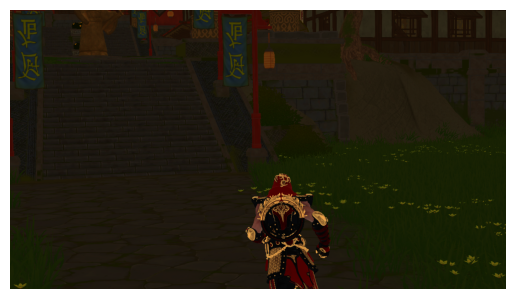

In [27]:
root_dir = 'D:\Datasets\DataV1'

zip_file_path = os.path.join(root_dir, dataset.compressed_files[0])

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file = dataset._get_hr_gb_path(32, GB_Type.BASE_COLOR)
    # Load the image to a buffer
    buffer = zip_ref.read(file)
    image = ImageUtils.decode_exr_image_opencv(buffer)

# Display the image
ImageUtils.display_image(image)
    